# 1. Imports

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
import random
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import numpy as np


# 2. Dataset und DataLoader

In [5]:
# Pfad zum Datenordner (wo 'clean' und 'stego' liegen)
data_dir_train = r"C:\Users\Flavio\Bachelorarbeit\LSB\data_old\train"
data_dir_test = r"C:\Users\Flavio\Bachelorarbeit\LSB\data_old\test"
data_dir_val = r"C:\Users\Flavio\Bachelorarbeit\LSB\data_old\val"

image_paths_train = []
image_paths_test = []
image_paths_val = []
labels_train = []
labels_test = []
labels_val = []

images_train = []
images_test = []
images_val = []

for label, subdir in enumerate(['clean', 'stego']):
            path = os.path.join(data_dir_train, subdir)
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                image_paths_train.append(img_path)
                labels_train.append(label)

for label, subdir in enumerate(['clean', 'stego']):
            path = os.path.join(data_dir_test, subdir)
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                image_paths_test.append(img_path)
                labels_test.append(label)

for label, subdir in enumerate(['clean', 'stego']):
            path = os.path.join(data_dir_val, subdir)
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                image_paths_val.append(img_path)
                labels_val.append(label)


def load_images(image_paths):
    images = []
    for path in image_paths:
        img = Image.open(path).convert("RGBA")  # RGBA-Bilder laden
        images.append(np.array(img))  # In ein numpy-Array umwandeln
    return np.array(images)

images_test = load_images(image_paths_test)
images_train = load_images(image_paths_train)
images_val = load_images(image_paths_val)

class PatchDataset(Dataset):
    def __init__(self, images, labels, patch_size=128):
        self.images = images
        self.labels = labels
        self.patch_size = patch_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Zufälligen Patch extrahieren
        h, w, _ = image.shape
        top = random.randint(0, h - self.patch_size)
        left = random.randint(0, w - self.patch_size)
        patch = image[top:top + self.patch_size, left:left + self.patch_size]

        # ToTensor transformieren
        patch = ToTensor()(patch)
        return patch, label
    


# 3. Train-/Val-/Test-Split

In [6]:

patch_dataset_train = PatchDataset(images_train, labels_train)
patch_dataset_test = PatchDataset(images_test, labels_test)
patch_dataset_val = PatchDataset(images_val, labels_val)

# dataloader = DataLoader(patch_dataset, batch_size=16, shuffle=True)
train_loader = DataLoader(patch_dataset_train, batch_size=16, shuffle=True)
val_loader   = DataLoader(patch_dataset_test, batch_size=16, shuffle=False)
test_loader  = DataLoader(patch_dataset_val, batch_size=16, shuffle=False)

print("Train:", len(patch_dataset_train), "Val:", len(patch_dataset_val), "Test:", len(patch_dataset_test))


Train: 16000 Val: 8000 Test: 8000


# 4. High-Pass-Filter-Layer (optional)

In [43]:
class HighpassConv(nn.Module):
    def __init__(self):
        super(HighpassConv, self).__init__()
        # Laplacian Filter (3x3); 
        kernel = torch.tensor([[0, -1, 0],
                               [-1, 4, -1],
                               [0, -1, 0]], dtype=torch.float32)
        # 1x1-Conv-Layer mit diesem Filter als festen Filter
        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        # Gewichte setzen und einfrieren (man könnte auch feintuning erlauben)
        self.conv.weight.data = kernel.unsqueeze(0).unsqueeze(0)
        self.conv.weight.requires_grad = False  # hier true für feintuning

    def forward(self, x):
        return self.conv(x)

# 5. Residual Block (vereinfacht)

In [44]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, dilation=1, use_batchnorm=True):
        super(ResidualBlock, self).__init__()
        padding = dilation  # räumliche Auflösung erhalten
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(channels) if use_batchnorm else nn.Identity()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(channels) if use_batchnorm else nn.Identity()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)

# 6. Das Hauptmodell

In [11]:
class RGBA_LSB_StegoNet(nn.Module):
    def __init__(self, input_shape):
        super(RGBA_LSB_StegoNet, self).__init__()

        # Anpassung der ersten Convolutional Layer an 4 Kanäle (RGBA)
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=1, padding=1)  # 4 Input-Kanäle
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)

        # Res-Blöcke
        self.resblock1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.resblock2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        # Dynamische Berechnung der Flatten-Dimension
        self.flatten_size = self.calculate_flatten_size(input_shape)

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 2)  # Binary Classification: Normal oder Stego

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Erste Convolutional Layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # Res-Blöcke
        residual = x
        x = self.resblock1(x) + residual
        residual = x
        x = self.resblock2(x) + residual

        # Flattening
        x = x.view(x.size(0), -1)

        # Fully connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def calculate_flatten_size(self, input_shape):
        """
        Berechne die Dimension nach den Convolutional- und Res-Blöcken.
        """
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)  # Dummy-Eingabe basierend auf Patch-Größe
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))

            residual = x
            x = self.resblock1(x) + residual
            residual = x
            x = self.resblock2(x) + residual

            return x.numel()  # Anzahl der Elemente nach Flattening

# 7. Training & Validierung

In [12]:
# 3. Modell und Loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RGBA_LSB_StegoNet((4, 128, 128)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

# 4. Training und Validierung
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Forward-Pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward-Pass und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metriken aktualisieren
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)

            # Forward-Pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Metriken aktualisieren
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

# Haupt-Trainingsloop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}\n")

print("Training abgeschlossen.")

Epoch 1/5


Train Loss: 0.6044 | Train Accuracy: 0.7706
Val Loss: 0.5641 | Val Accuracy: 0.7500

Epoch 2/5


Train Loss: 0.5628 | Train Accuracy: 0.7500
Val Loss: 0.5623 | Val Accuracy: 0.7500

Epoch 3/5


Train Loss: 0.5625 | Train Accuracy: 0.7500
Val Loss: 0.5623 | Val Accuracy: 0.7500

Epoch 4/5


Train Loss: 0.5624 | Train Accuracy: 0.7500
Val Loss: 0.5624 | Val Accuracy: 0.7500

Epoch 5/5


Train Loss: 0.5624 | Train Accuracy: 0.7500
Val Loss: 0.5623 | Val Accuracy: 0.7500

Training abgeschlossen.


# 8. Testen auf dem Test-Set

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x = test_x.to(device)
        test_y = test_y.to(device)
        
        outputs = model(test_x)
        loss_val = criterion(outputs, test_y)
        test_loss += loss_val.item()
        
        _, predicted = outputs.max(1)
        correct += (predicted == test_y).sum().item()
        total += test_y.size(0)

test_loss /= len(test_loader)
test_acc = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


In [ ]:
model.eval()  # Modell in Evaluierungsmodus
all_predictions = {}

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Wahrscheinlichkeiten für jede Klasse
        preds = probabilities.argmax(dim=1)  # Höchste Wahrscheinlichkeiten
        
        # Speichere Ergebnisse in einem Dictionary
        for i, (prob, pred, label) in enumerate(zip(probabilities, preds, labels)):
            all_predictions[i] = {
                "true_label": label.item(),
                "predicted_label": pred.item(),
                "probability": prob[pred].item(),  # Wahrscheinlichkeit vorhergesagter Klasse
            }

for idx, result in all_predictions.items():
    print(
        f"Bild-Index: {idx}  ->  "
        f"True Label: {result['true_label']}  |  "
        f"Vorhersage: {result['predicted_label']}  |  "
        f"Wahrscheinlichkeit: {result['probability']:.4f}"
    )


## 9. Weitere Analyse

In [ ]:
import matplotlib.pyplot as plt

# Visualisierung der Feature Maps
def visualize_feature_maps(model, image):
    model.eval()
    activations = []
    
    # Aktivierungen speichern
    def hook_fn(module, input, output):
        activations.append(output)
    
    # Registriere Hook auf gewünschter Schicht
    layer = model.conv1  # Schicht die ich haben will
    hook = layer.register_forward_hook(hook_fn)
    
    # Leite Bild durch Modell
    #with torch.no_grad():
    image = image.unsqueeze(0).to(device)  # Batch-Dimension hinzufügen
    model(image)
    
    # Entferne Hook
    hook.remove()
    
    # Feature Maps visualisieren
    feature_maps = activations[0].cpu().squeeze(0)  # Batch-Dimension entfernen
    num_maps = feature_maps.shape[0]
    
    fig, axes = plt.subplots(1, min(8, num_maps), figsize=(15, 15))
    for i in range(min(8, num_maps)):  # Anzahl an Karten die angezeigt werden
        ax = axes[i]
        ax.imshow(feature_maps[i].detach().numpy(), cmap='viridis')
        ax.axis('off')
    plt.show()

# Aufruf
test_image, _ = test_dataset[0]
visualize_feature_maps(model, test_image)


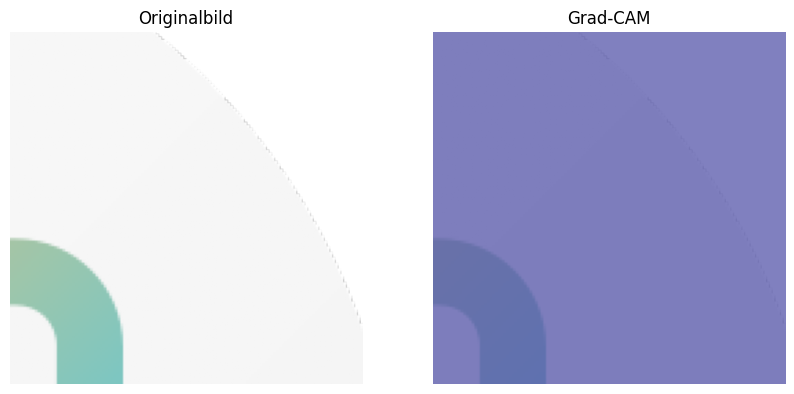

In [17]:
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

def visualize_gradcam(model, image, device):
    model.eval()

    # Grad-CAM-Objekt erstellen und Zielschicht festlegen (z.B. letzte Convolutional-Schicht)
    target_layer = model.resblock2[0]  # Erste Schicht des letzten Res-Blocks
    cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

    image = image.unsqueeze(0).to(device)  # Batch-Dimension hinzufügen

    # Vorhersage
    output = model(image)
    prediction = output.argmax(dim=1).item()

    # Grad-CAM-Karte berechnen
    activation_map = cam_extractor(prediction, output)

    # Visualisieren
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Originalbild")
    plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # RGBA-Darstellung
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy(), alpha=0.5)  # Originalbild
    plt.imshow(activation_map[0].squeeze().cpu().numpy(), cmap='jet', alpha=0.5)  # Grad-CAM-Karte
    plt.axis('off')

    plt.show()

image, _ = patch_dataset_test[0]
visualize_gradcam(model, image, device)


## 10. To Do`s

Sachen noch zum Evaluieren des Models:
- versch. Highpass Filter verwenden, gucken was passiert (ist jetziger Optimal?)
- nachsehen inwiefern der die entscheidenen Pixel gehighlighted werden (mit Grad-Cam Pixel Highlights ansehen und dann schauen welche Pixel am meisten verändert wurden zum original Bild)
- andere Stego implemetierungen nutzen/ sehen ob das auch erkennt wird S- Uniward oder WOW zb
- Model struktur evtl. nochmals anpassen => wie reagiert es darauf => rausfinden was jetzt der springende Punkt war
- model auf härtere Daten testen => bis auf wie viel byte embeddete Daten kann ich runter gehen??


Ansonsten:
- implementieren einer SVM die das Probolem lösen kann (Im Titel steht comparative Study) => wäre interessant zu sehen wie andere RL Algorithmen performen => starkes Preprocessing durch X2 usw. nötig
- Schreiben anfangen!! Dann sehen wie viel Zeit übrig ist für weitere Untersuchungen
- Falls ich nochmal komplexere Daten verwende denken an: Daten-Augmentierung, Hyperparametertuning, Curriculum Training, Early Stopping, Learning-Rate-Scheduler, Cross-Validation 

